# Pipeline de processamento dos dados FAMES
Lista de tarefas:
1. Definir canais a serem utilizados
1. Deadtime correction. Máximo deve ser de até uns 10 MHz, acima disso é dificil de corrigir
1. Background subtraction
1. Médias
1. Calculo de extinction rate aerosol com Klett e Raman combinado
1. Calculo backscattering para aerosol
1. Calculo mixing ratio metano/co2 para eficiencia de combustão
1. Calculo mixing ratio metano/n2 para concentração de metano
1. Calcula mixing ration co2/n2 para concentração de co2
1. TODO Precisa verificar se não tem crosstalk entre o 355 e 353
1. TODO Verificar influencia da fluorescencia


In [1]:
import numpy as np
import matplotlib.pyplot as plt
import glob
import os
import math
from scipy.signal import find_peaks
from importlib import reload
import json
import pandas as pd


from lifa.licel import LicelLidarMeasurement
from lifa.processing import fit_checks
from lifa.processing import pre_processing
from lifa.processing import helper_functions
from lifa.processing import raman_mixing_ratio
from lifa.processing import raman_retrievals

## Abre arquivos de dados

In [2]:
files = [ r"d:\Local - FAMES\Medidas\CEPEMA-setembro2025-20250917T201022Z-1-001\CEPEMA-setembro2025\20250912 GRID\a2591218.354537"]

files = [ r'd:\Local - FAMES\Medidas\CEPEMA-setembro2025-20250917T201022Z-1-001\CEPEMA-setembro2025\20250912 GRID\a2591218.382991',
          r'd:\Local - FAMES\Medidas\CEPEMA-setembro2025-20250917T201022Z-1-001\CEPEMA-setembro2025\20250912 GRID\a2591218.354537',
          r'd:\Local - FAMES\Medidas\CEPEMA-setembro2025-20250917T201022Z-1-001\CEPEMA-setembro2025\20250912 GRID\a2591218.362648',
          r'd:\Local - FAMES\Medidas\CEPEMA-setembro2025-20250917T201022Z-1-001\CEPEMA-setembro2025\20250912 GRID\a2591218.370762',
          r'd:\Local - FAMES\Medidas\CEPEMA-setembro2025-20250917T201022Z-1-001\CEPEMA-setembro2025\20250912 GRID\a2591218.374877' ]


files = [ r'd:\FAMES\Medidas\CEPEMA-setembro2025-20250917T201022Z-1-001\CEPEMA-setembro2025\20250829 CEPEMA FAMES FULL\a2590216.531835']

files = [ r'.\sample_data\20241204_CEPEMA_FLARE_acima da chama_p=23\a24C0505.552826', 
          r'.\sample_data\20241204_CEPEMA_FLARE_acima da chama_p=23\a24C0505.560971', 
          r'.\sample_data\20241204_CEPEMA_FLARE_acima da chama_p=23\a24C0505.565115', 
          r'.\sample_data\20241204_CEPEMA_FLARE_acima da chama_p=23\a24C0505.573260', 
          r'.\sample_data\20241204_CEPEMA_FLARE_acima da chama_p=23\a24C0505.581404', 
          r'.\sample_data\20241204_CEPEMA_FLARE_acima da chama_p=23\a24C0505.585549', 
          r'.\sample_data\20241204_CEPEMA_FLARE_acima da chama_p=23\a24C0505.593694', 
          r'.\sample_data\20241204_CEPEMA_FLARE_acima da chama_p=23\a24C0506.001838', 
          r'.\sample_data\20241204_CEPEMA_FLARE_acima da chama_p=23\a24C0506.005984', 
          r'.\sample_data\20241204_CEPEMA_FLARE_acima da chama_p=23\a24C0506.014128',
         ]

#files = [r'd:\FAMES\Medidas\Medidas CEPEMA\20241204-Alex e Jairo\Acima da chama p=23 mm\a24C0506.014128']

#files = files[2:4]

dead_time = 1/240   #(1/200 MHz)

measurements = LicelLidarMeasurement(files)

upper_signal = {}
upper_signal['n2_raman_353'] = measurements.channels['00353.o_ph']
upper_signal['rayleigh_355'] = measurements.channels['00355.o_ph']
upper_signal['co2_raman_371'] = measurements.channels['00371.o_ph']
upper_signal['ch4_raman_395_s'] = measurements.channels['00395.s_ph']
upper_signal['ch4_raman_395_p'] = measurements.channels['00395.p_ph']
upper_signal['fluo_460'] = measurements.channels['00460.o_ph']
upper_signal['n2_raman_530'] = measurements.channels['00530.o_ph']
upper_signal['rayleigh_532'] = measurements.channels['00532.o_ph']

lower_signal = {}
lower_signal['n2_raman_353'] = measurements.channels['00353.o_an']
lower_signal['rayleigh_355'] = measurements.channels['00355.o_an']
lower_signal['co2_raman_371'] = measurements.channels['00371.o_an']
lower_signal['ch4_raman_395_s'] = measurements.channels['00395.s_an']
lower_signal['ch4_raman_395_p'] = measurements.channels['00395.p_an']
lower_signal['fluo_460'] = measurements.channels['00460.o_an']
lower_signal['n2_raman_530'] = measurements.channels['00530.o_an']
lower_signal['rayleigh_532'] = measurements.channels['00532.o_an']


z = measurements.channels['00355.o_an'].z

bin_width = measurements.channels['00355.o_an'].resolution

### Pre processamento

In [3]:

# pre process
idx_min = 12000
idx_max = 15000

for key,val in lower_signal.items():
    if lower_signal[key].is_photon_counting:
        lower_signal[key] = pre_processing.correct_count_rate_dead_time_nonparalyzable(lower_signal[key].average_profile(), dead_time)
        lower_signal[key], background_mean, background_std = pre_processing.subtract_background(lower_signal[key], idx_min, idx_max)
        signal_type = "photon counting rate [MHz]" 
    else:
        lower_signal[key], background_mean, background_std = pre_processing.subtract_background(lower_signal[key].average_profile(), idx_min, idx_max)
        signal_type = "analog [mV]"
    print('Signal: {}, type: {}, background mean: {}, std {}'.format(key, signal_type, background_mean, background_std))

for key,val in upper_signal.items():
    if upper_signal[key].is_photon_counting:
        upper_signal[key] = pre_processing.correct_count_rate_dead_time_nonparalyzable(upper_signal[key].average_profile(), dead_time)
        upper_signal[key], background_mean, background_std = pre_processing.subtract_background(upper_signal[key], idx_min, idx_max)
        signal_type = "photon counting rate [MHz]" 
    else:
        upper_signal[key], background_mean, background_std = pre_processing.subtract_background(upper_signal[key].average_profile(), idx_min, idx_max)
        signal_type = "analog [mV]"
    print('Signal: {}, type: {}, background mean: {}, std {}'.format(key, signal_type, background_mean, background_std))

Signal: n2_raman_353, type: analog [mV], background mean: 5.499057742042198, std 0.0001427837917072794
Signal: rayleigh_355, type: analog [mV], background mean: 5.201110827473698, std 0.00028024133183570315
Signal: co2_raman_371, type: analog [mV], background mean: 5.481615084103462, std 0.00014363333125242336
Signal: ch4_raman_395_s, type: analog [mV], background mean: 5.533497211277708, std 0.00014403793949399908
Signal: ch4_raman_395_p, type: analog [mV], background mean: 5.550917341162769, std 0.0001500516396744898
Signal: fluo_460, type: analog [mV], background mean: 5.545413261138605, std 0.00033528792307830734
Signal: n2_raman_530, type: analog [mV], background mean: 5.58838910181573, std 0.00015518869881978525
Signal: rayleigh_532, type: analog [mV], background mean: 5.3516383309413, std 0.00028232735835516463
Signal: n2_raman_353, type: photon counting rate [MHz], background mean: 6.0252066214732365e-05, std 0.0005537424212356596
Signal: rayleigh_355, type: photon counting rat

In [4]:
# Escolhe sinais que vamos utilizar e faz bin shift para alinhar
signal = {}
signal['n2_raman_353'] = lower_signal['n2_raman_353']
signal['rayleigh_355'] = lower_signal['rayleigh_355']
signal['co2_raman_371'] = pre_processing.correct_trigger_delay_bins(upper_signal['co2_raman_371'], 4)
signal['ch4_raman_395_s'] = pre_processing.correct_trigger_delay_bins(upper_signal['ch4_raman_395_s'], 4)
signal['ch4_raman_395_p'] = pre_processing.correct_trigger_delay_bins(upper_signal['ch4_raman_395_p'], 4)
signal['fluo_460'] = pre_processing.correct_trigger_delay_bins(lower_signal['fluo_460'], 1)
signal['n2_raman_530'] = lower_signal['n2_raman_530']
signal['rayleigh_532'] = lower_signal['rayleigh_532']

# Posição do flare em metros
flare_pos = z[helper_functions.find_nearest(400, z)]

### Visualização dos dados
Visualizção dos dados em escala linear em sem correção de range. Isso permite avaliar o seguinte:
- Sincronia entre os canais, posição do pico
- Sinais de contagem de fótons devem ser no máximo até 10 MHz, para evitar deformação por dead time

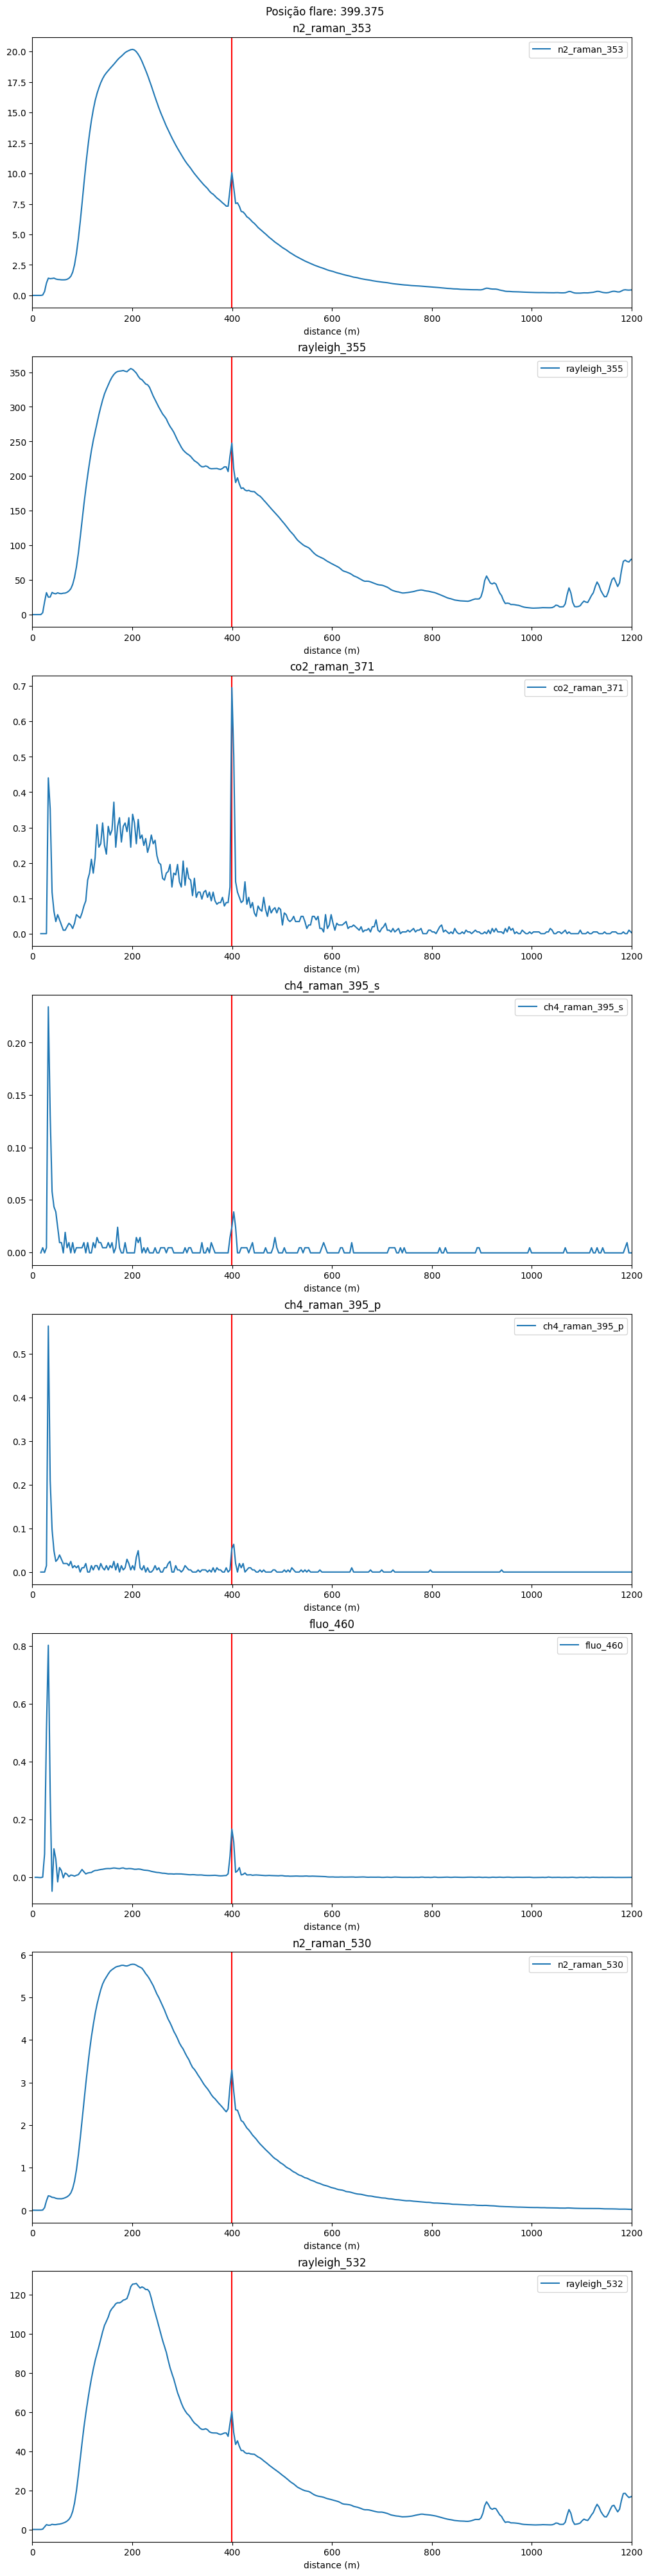

In [5]:
# apresenta todos sinais
#number_traces = len(licel_channels_names)
fig, ax = plt.subplots(nrows=len(upper_signal), figsize=(10,40), layout='constrained')
#plt.title('Photon-counting signal')
#fig.suptitle('Signals')

plt.suptitle('Posição flare: {}'.format(flare_pos))
for i,(key, data) in enumerate(signal.items()):
    ax[i].axvline(flare_pos, 0, 1, color='r')
    
    ax[i].plot(z, data, label=key)
    
    #plt.plot(z, non_paralyzable_corrected, 'g', label='Non paralyzable')

    #ax[i].plot(trace[0], trace[1], label=name, marker=',')
    ax[i].set_title(key)
    #ax[i].grid(True, 'both')
    #ax[i].minorticks_on()
    ax[i].set_xlabel('distance (m)')
    #ax[i].set_ylabel('signal (mV)')
    ax[i].legend(loc='upper right')
    #ax[i].set_yscale('log')
    ax[i].set_xlim(0,1200)

### Crosstalk
Remove crosstalk do 355 no 353. Notar pico em 1000 metros nos canais elásticos. Somente em 353 ele aparece (não em 530). Não pode ser fluorescencia, então deve ser crosstalk com 355.

(0.0, 3000.0)

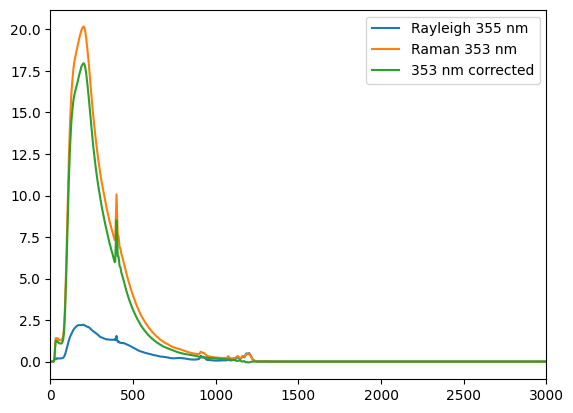

In [6]:
cross_talk_correction = 160
plt.plot(z, signal['rayleigh_355']/cross_talk_correction, label = 'Rayleigh 355 nm')
plt.plot(z, signal['n2_raman_353'],  label = 'Raman 353 nm')
plt.plot(z, signal['n2_raman_353'] - (signal['rayleigh_355']/cross_talk_correction),  label = '353 nm corrected')

plt.legend()
#plt.yscale('log')

plt.xlim(0,3000)


In [7]:
# Corrige cross talk do 355 no 353 nm
signal['n2_raman_353'] = signal['n2_raman_353'] - (signal['rayleigh_355']/cross_talk_correction)

### Vizualização dados range corrected
Aqui é possível avaliar a qualidade dos dados e até onde eles são válidos.
Os dados são validos somente até o ponto em que a curva cai e começa subir novamente. Deste ponto em diante é somente ruído da detecção que está sendo "amplificado" pela correção de distância.

In [8]:
# aplica range correction
signal_rc = {}
for key,val in signal.items():
    signal_rc[key] = pre_processing.apply_range_correction(val, z)

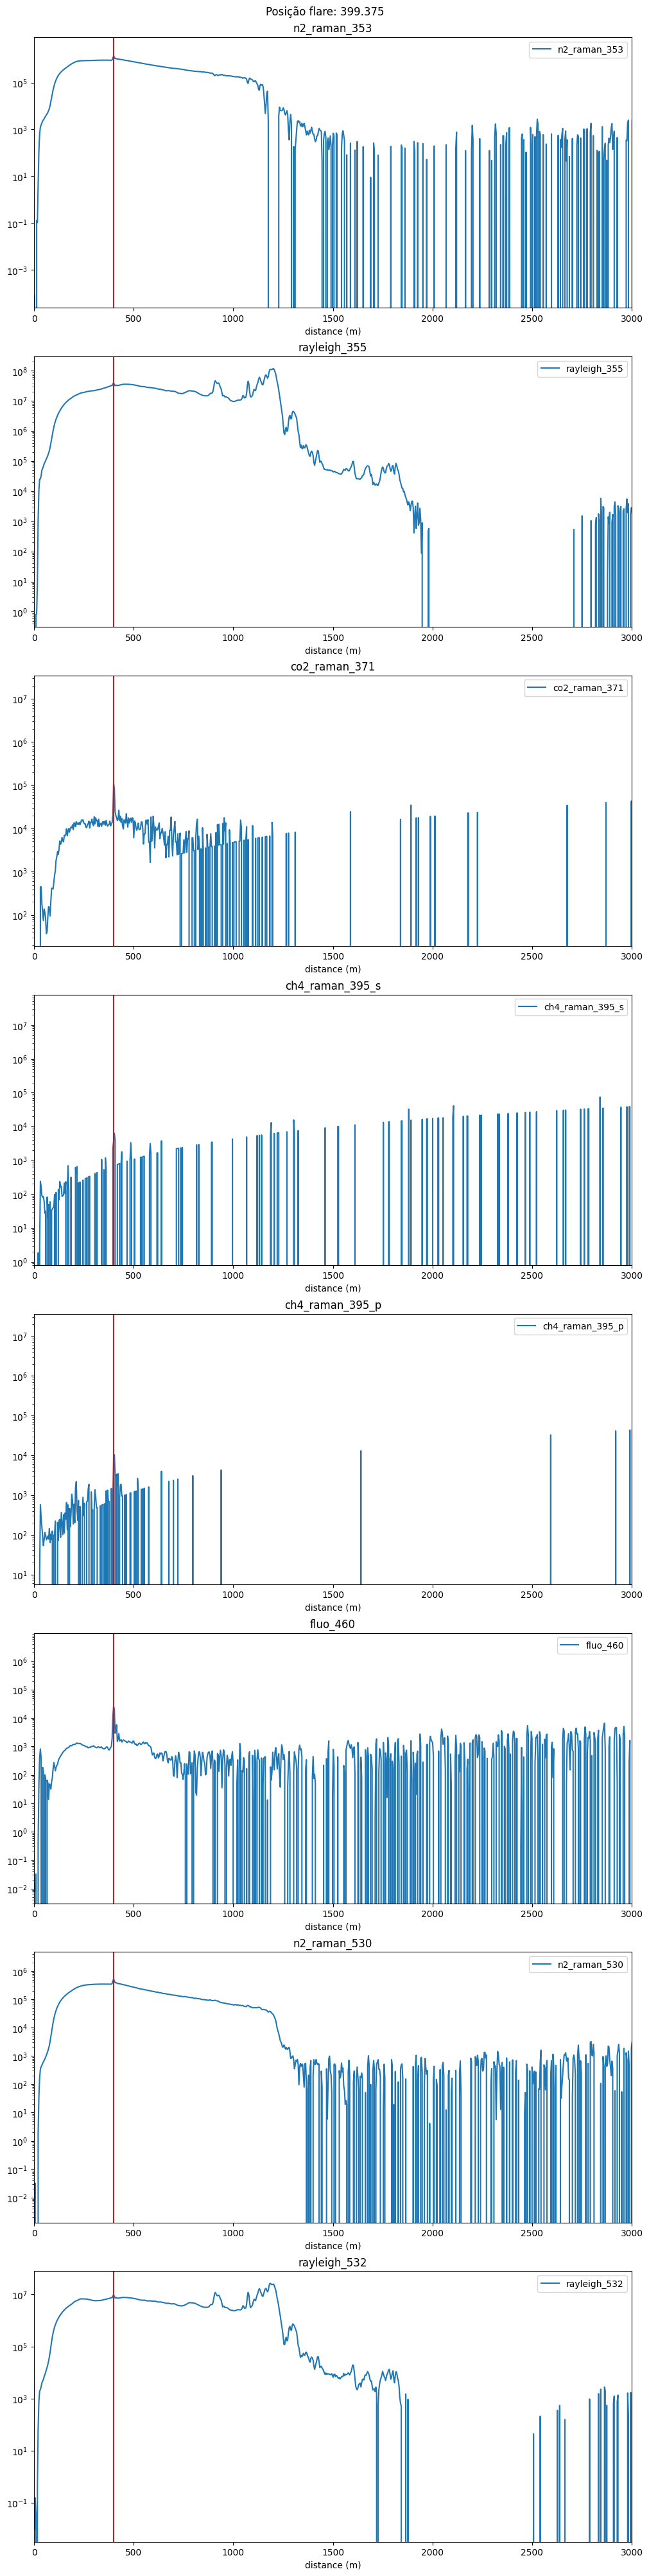

In [9]:
# apresenta todos sinais
#number_traces = len(licel_channels_names)
fig, ax = plt.subplots(nrows=len(upper_signal), figsize=(10,40), layout='constrained')
#plt.title('Photon-counting signal')
#fig.suptitle('Signals')

plt.suptitle('Posição flare: {}'.format(flare_pos))
for i,(key, data) in enumerate(signal_rc.items()):
    ax[i].plot(z, data, label=key)
    ax[i].axvline(flare_pos, 0, 1, color='r')
    
    #plt.plot(z, non_paralyzable_corrected, 'g', label='Non paralyzable')

    #ax[i].plot(trace[0], trace[1], label=name, marker=',')
    ax[i].set_title(key)
    #ax[i].grid(True, 'both')
    #ax[i].minorticks_on()
    ax[i].set_xlabel('distance (m)')
    #ax[i].set_ylabel('signal (mV)')
    ax[i].legend(loc='upper right')
    ax[i].set_yscale('log')
    ax[i].set_xlim(0,3000)


## Mixing ratio

O sinal lidar é muito ruim. O ângulo é muito baixo e não é possível pegar atmosfera limpa onde identificamos somente espalhamento molecular. A distância máxima com dados é de aproximadamente 1700 metros. Isso num angulo aproximado de 12 graus, é uma diferenca de altura de XXXX...Estimar o esplhamento molecular após isso...

Por enquanto não vamos calcular o exticntion ratio do aerosol, somente o teórico molecular. Não sei como estimar o extinction ration para aer (precisa??)

In [10]:
elevation_angle = 12
elevation = 0
bin_min = helper_functions.find_nearest(z, 300)
bin_max = helper_functions.find_nearest(z, 600)
height = z * math.sin(math.radians(elevation_angle)) + elevation 

# Modelo Padrão Atmosfera
pressure, temperature, density = helper_functions.standard_atmosphere(height)


# Calcula extinction rate para aerosol a partir de sinal Raman
alpha_aer =  raman_retrievals.raman_extinction(signal_rc['n2_raman_353'],    # array sinal raman com range correction
                                 bin_width,   # tamanho de cada bin em metros
                                 355, # comprimento de onda do laser/rayleigh
                                 353,    # comprimento de onda sinal raman
                                 angstrom_aerosol=1,    # fator de relação. Geralmente por volta de 1
                                 temperature=temperature,   # array com temperatura do ar
                                 pressure=pressure,     # array com pressão do ar
                                 window_size=5,     # deve ser algum tipo de janela para filtro
                                 order = 4)         # ordem de algum tipo de filtro


# O calculo de extinction rate por ramana não fica bom com o sinal Raman do N2. Usa tudo zero por enquanto
alpha_aer = np.zeros_like(height)


### CO2

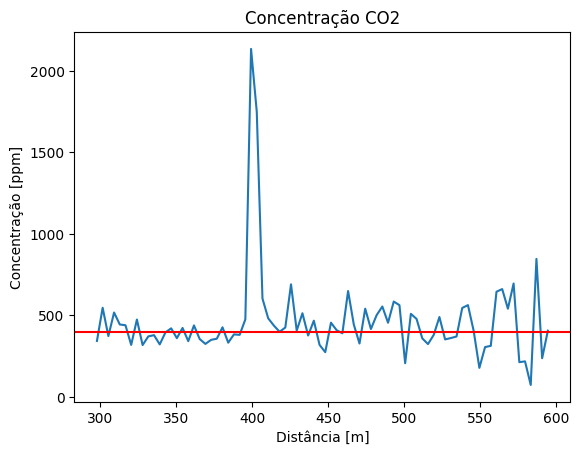

In [11]:
# Mixing ration CO2 e N2
co2_calib = 26000   
co2_ref = 400 # Concentração na atmosfera é aproximadamente 400 ppm
co2_mixing_ratio = raman_mixing_ratio.raman_mixing_ratio(signal_rc['co2_raman_371'], 
                                      signal_rc['n2_raman_353'], 
                                      3.75, 
                                      alpha_aer, 
                                      co2_calib, 
                                      371, 
                                      353, 
                                      pressure, 
                                      temperature)

plt.plot(z[bin_min:bin_max], co2_mixing_ratio[bin_min:bin_max])
plt.axhline(co2_ref, 0, 1, color='r')
plt.title('Concentração CO2')
plt.xlabel('Distância [m]')
plt.ylabel('Concentração [ppm]')
plt.show()

### CH4

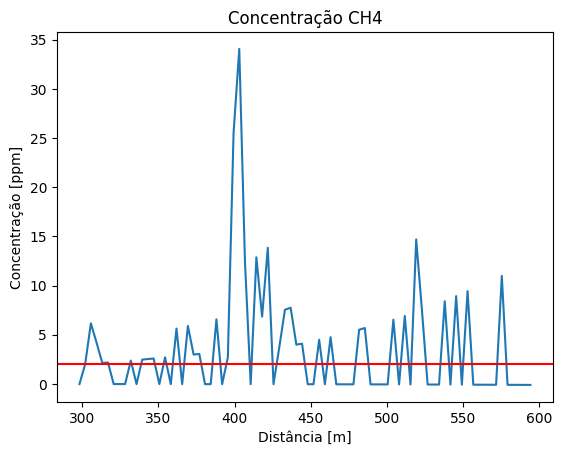

In [12]:
# Mixing ration CH4 e N2
ch4_calib = 4000   
ch4_ref = 2 # Concentração na atmosfera é aproximadamente 2 ppm
ch4_mixing_ratio = raman_mixing_ratio.raman_mixing_ratio(signal_rc['ch4_raman_395_p'], 
                                      signal_rc['n2_raman_353'], 
                                      3.75, 
                                      alpha_aer, 
                                      ch4_calib, 
                                      395, 
                                      353, 
                                      pressure, 
                                      temperature)

plt.plot(z[bin_min:bin_max], ch4_mixing_ratio[bin_min:bin_max])
plt.axhline(ch4_ref, 0, 1, color='r')
plt.title('Concentração CH4')
plt.xlabel('Distância [m]')
plt.ylabel('Concentração [ppm]')
plt.show()

### CE Mixing Ratio

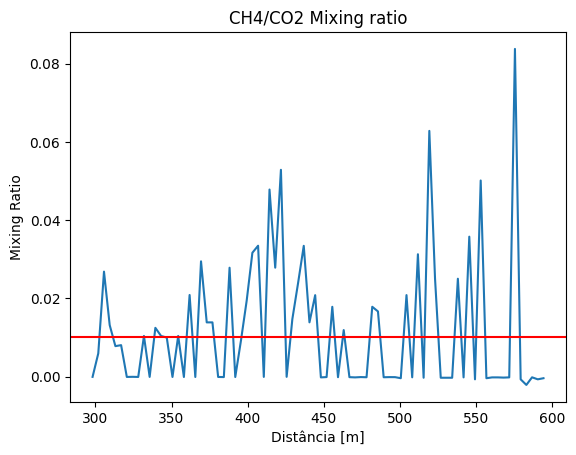

In [13]:
# Mixing ration CH4 e CO2
ce_calib = 0.25  
ce_mixing_ratio_ref = 0.01 # CE mixing ratio é 2/200 = 0,01
ce_mixing_ratio = raman_mixing_ratio.raman_mixing_ratio(signal_rc['ch4_raman_395_p'], 
                                      signal_rc['co2_raman_371'], 
                                      3.75, 
                                      alpha_aer, 
                                      ce_calib, 
                                      395, 
                                      371, 
                                      pressure, 
                                      temperature)

plt.plot(z[bin_min:bin_max], ce_mixing_ratio[bin_min:bin_max])
plt.axhline(ce_mixing_ratio_ref, 0, 1, color='r')
plt.title('CH4/CO2 Mixing ratio')
plt.xlabel('Distância [m]')
plt.ylabel('Mixing Ratio')
plt.show()

### CE

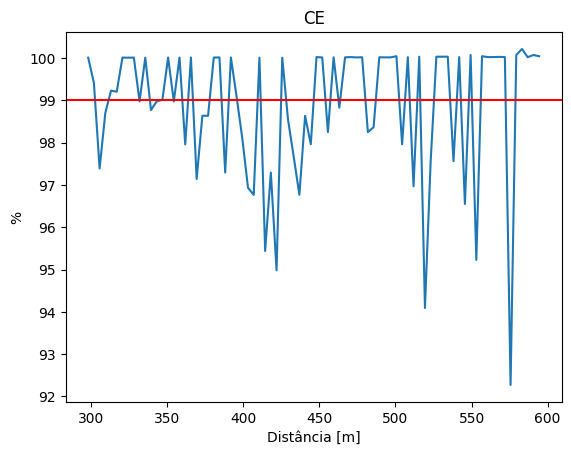

In [14]:
ce = 1/(1 + ce_mixing_ratio) * 100

ce_ref = 99 # CE para atmosfera é algo como 99. Não sei como converter isso para 100%...preciso pensar um pouco
plt.plot(z[bin_min:bin_max], ce[bin_min:bin_max])
plt.axhline(ce_ref, 0, 1, color='r')
plt.title('CE')
plt.xlabel('Distância [m]')
plt.ylabel('%')
plt.show()

### Fluorescência
Indicador e fluorescência para sabermos qual era o nível de fluorescencia comparado com o sinal de N2. Retorna valor em %.

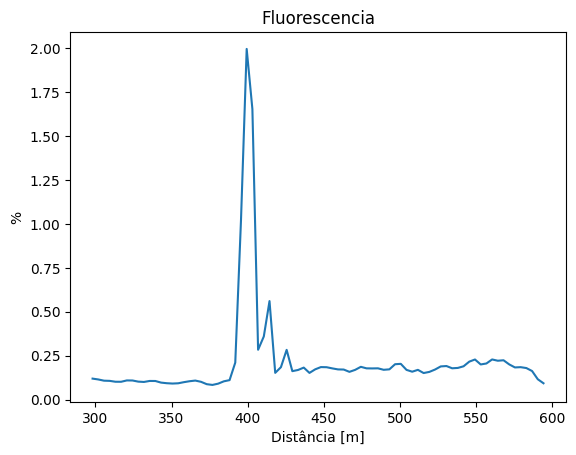

In [15]:
# Mixing ration CH4 e CO2
fluo_calib = 100
#ce_mixing_ratio_ref = 0.01 # CE mixing ratio é 2/200 = 0,01
fluo_mixing_ratio = raman_mixing_ratio.raman_mixing_ratio(signal_rc['fluo_460'], 
                                      signal_rc['n2_raman_353'], 
                                      3.75, 
                                      alpha_aer, 
                                      fluo_calib, 
                                      460, 
                                      353, 
                                      pressure, 
                                      temperature)

plt.plot(z[bin_min:bin_max], fluo_mixing_ratio[bin_min:bin_max])
#plt.axhline(fluo_mixing_ratio_ref, 0, 1, color='r')
plt.title('Fluorescencia')
plt.xlabel('Distância [m]')
plt.ylabel('%')
plt.show()

### Faz resumo de dados
1. Detecta posição do flare
1. Coleta dados no pico e fora dele

In [16]:
min_distance_idx = helper_functions.find_nearest(100, z)
max_distance_idx = helper_functions.find_nearest(600, z)
peaks, _ = find_peaks(signal['rayleigh_355'][min_distance_idx: max_distance_idx], width=1,  threshold=3)
peak_idx =  peaks[0] + min_distance_idx
pre_peak_idx = peak_idx - 10
print(peak_idx)

106


(0.0, 300.0)

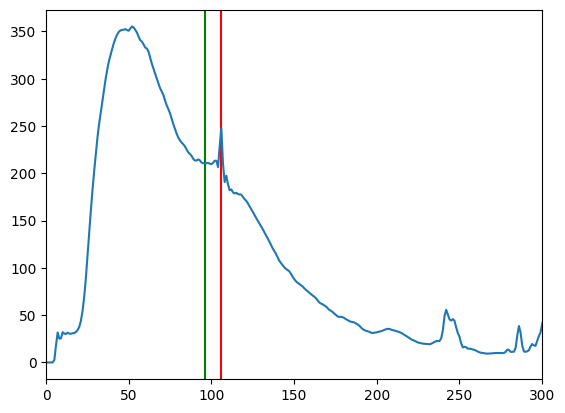

In [17]:
plt.axvline(peak_idx, 0, 1, color='r')
plt.axvline(pre_peak_idx, 0, 1, color='g')
plt.plot(signal['rayleigh_355'])
plt.xlim(0,300)

In [18]:
# Coleta dados
output = {
    'files': measurements.files,
    'start_time' : measurements.info['start_time'],
    'stop_time' : measurements.info['stop_time'],
    'duration' : measurements.info['duration'],
    'cross_talk_355_353': cross_talk_correction,
    'ch4_cal': ch4_calib,
    'co2_cal': co2_calib,
    'ce_cal': ce_calib,
    'fluo_cal': fluo_calib,
    'z_ref': float(z[pre_peak_idx]),
    'co2_ref': float(co2_mixing_ratio[pre_peak_idx]),
    'ch4_ref': float(ch4_mixing_ratio[pre_peak_idx]),
    'ce_ref': float(ce[pre_peak_idx]),
    'ce_m_ref': float(ce_mixing_ratio[pre_peak_idx]),
    'fluo_ref': float(fluo_mixing_ratio[pre_peak_idx]),
    'z': float(z[peak_idx]),
    'co2': float(co2_mixing_ratio[peak_idx]),
    'ch4': float(ch4_mixing_ratio[peak_idx]),
    'ce': float(ce[peak_idx]),
    'ce_m': float(ce_mixing_ratio[peak_idx]),
    'fluo': float(fluo_mixing_ratio[peak_idx]),
},

In [19]:
# Cria datafram Pandas
df = pd.DataFrame.from_dict(output)

In [20]:
df

,files,start_time,stop_time,duration,cross_talk_355_353,ch4_cal,co2_cal,ce_cal,fluo_cal,z_ref,...,ch4_ref,ce_ref,ce_m_ref,fluo_ref,z,co2,ch4,ce,ce_m,fluo
0,[.\sample_data\20241204_CEPEMA_FLARE_acima da ...,2024-12-05 05:56:10+00:00,2024-12-05 05:57:32+00:00,0 days 00:01:22,160,4000,26000,0.25,100,361.875,...,5.628888,97.957345,0.020852,0.105045,399.375,2134.317816,25.48768,98.096392,0.019405,1.994683


In [7]:
import lifa.fames.process_mixing_ratio as process_mixing_ratio

df1 = process_mixing_ratio.emissions(files[0:2], process_mixing_ratio.config)
df2 = process_mixing_ratio.emissions(files[4:6], process_mixing_ratio.config)
df = pd.concat([df1, df2], ignore_index=True)
df

,start_time,stop_time,duration,cross_talk_355_353,ch4_cal,co2_cal,ce_cal,fluo_cal,z_ref,co2_ref,...,ce_m_ref,fluo_ref,z,co2,ch4,ce,ce_m,fluo,number_of_files,files
0,2024-12-05 05:54:47+00:00,2024-12-05 05:56:09+00:00,0 days 00:01:22,160,4000,26000,0.25,100,361.875,427.802385,...,-0.000076,0.095062,399.375,2122.426762,35.323394,97.366740,0.027045,3.394469,2,[.\sample_data\20241204_CEPEMA_FLARE_acima da ...
1,2024-12-05 05:57:33+00:00,2024-12-05 05:58:55+00:00,0 days 00:01:22,160,4000,26000,0.25,100,361.875,415.971838,...,0.010836,0.101929,399.375,2004.830204,24.459739,98.055976,0.019826,2.322261,2,[.\sample_data\20241204_CEPEMA_FLARE_acima da ...


In [30]:
def group_files(L, size, step):
    starts = range(0, len(L), step)
    stops = [x + size for x in starts]
    groups = [(L*2)[start:stop] for start, stop in zip(starts, stops)]
    return groups

group = group_files(files, 5, 1)
results = []
for f in group:
    df = process_mixing_ratio.emissions(f, process_mixing_ratio.config)
    results.append(df)
emissions = pd.concat(results, ignore_index=True)

In [36]:
files = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
group_files(files, 5, 1)

[[1, 2, 3, 4, 5],
 [2, 3, 4, 5, 6],
 [3, 4, 5, 6, 7],
 [4, 5, 6, 7, 8],
 [5, 6, 7, 8, 9],
 [6, 7, 8, 9, 10],
 [7, 8, 9, 10, 1],
 [8, 9, 10, 1, 2],
 [9, 10, 1, 2, 3],
 [10, 1, 2, 3, 4]]

In [31]:
emissions

,start_time,stop_time,duration,cross_talk_355_353,ch4_cal,co2_cal,ce_cal,fluo_cal,z_ref,co2_ref,...,ce_m_ref,fluo_ref,z,co2,ch4,ce,ce_m,fluo,number_of_files,files
0,2024-12-05 05:54:47+00:00,2024-12-05 05:58:14+00:00,0 days 00:03:27,160,4000,26000,0.25,100,361.875,426.916007,...,0.008585,0.099089,399.375,2092.705972,31.529257,97.610240,0.024483,2.779213,5,[.\sample_data\20241204_CEPEMA_FLARE_acima da ...
1,2024-12-05 05:55:28+00:00,2024-12-05 05:58:55+00:00,0 days 00:03:27,160,4000,26000,0.25,100,361.875,416.557274,...,0.013143,0.101280,399.375,2145.284966,27.485905,97.960474,0.020820,2.502309,5,[.\sample_data\20241204_CEPEMA_FLARE_acima da ...
2,2024-12-05 05:56:10+00:00,2024-12-05 05:59:36+00:00,0 days 00:03:26,160,4000,26000,0.25,100,361.875,435.654359,...,0.016674,0.105165,399.375,2076.274688,27.052811,97.926607,0.021173,2.326309,5,[.\sample_data\20241204_CEPEMA_FLARE_acima da ...
3,2024-12-05 05:56:51+00:00,2024-12-05 06:00:18+00:00,0 days 00:03:27,160,4000,26000,0.25,100,361.875,411.527445,...,0.013148,0.109881,399.375,2080.937007,28.520712,97.821345,0.022272,2.456920,5,[.\sample_data\20241204_CEPEMA_FLARE_acima da ...
4,2024-12-05 05:57:33+00:00,2024-12-05 06:00:59+00:00,0 days 00:03:26,160,4000,26000,0.25,100,361.875,457.814436,...,0.007782,0.110130,399.375,2052.191424,31.733400,97.548826,0.025128,2.867711,5,[.\sample_data\20241204_CEPEMA_FLARE_acima da ...
5,2024-12-05 05:58:14+00:00,2024-12-05 06:01:41+00:00,0 days 00:03:27,160,4000,26000,0.25,100,361.875,423.304975,...,0.008300,0.110077,399.375,2108.555794,33.121844,97.510936,0.025526,3.088150,5,[.\sample_data\20241204_CEPEMA_FLARE_acima da ...
6,2024-12-05 05:54:47+00:00,2024-12-05 06:01:41+00:00,0 days 00:06:54,160,4000,26000,0.25,100,361.875,433.348152,...,0.004046,0.108023,399.375,2058.139808,37.030362,97.159329,0.029237,3.358075,5,[.\sample_data\20241204_CEPEMA_FLARE_acima da ...
7,2024-12-05 05:54:47+00:00,2024-12-05 06:01:41+00:00,0 days 00:06:54,160,4000,26000,0.25,100,361.875,414.652692,...,-0.000078,0.104242,399.375,2125.288172,37.609718,97.204735,0.028756,3.546194,5,[.\sample_data\20241204_CEPEMA_FLARE_acima da ...
8,2024-12-05 05:54:47+00:00,2024-12-05 06:01:41+00:00,0 days 00:06:54,160,4000,26000,0.25,100,361.875,438.558846,...,0.004040,0.099541,399.375,2121.129827,36.243054,97.298427,0.027766,3.427958,5,[.\sample_data\20241204_CEPEMA_FLARE_acima da ...
9,2024-12-05 05:54:47+00:00,2024-12-05 06:01:41+00:00,0 days 00:06:54,160,4000,26000,0.25,100,361.875,391.852430,...,0.009220,0.099190,399.375,2151.478492,32.991506,97.568752,0.024918,3.012040,5,[.\sample_data\20241204_CEPEMA_FLARE_acima da ...


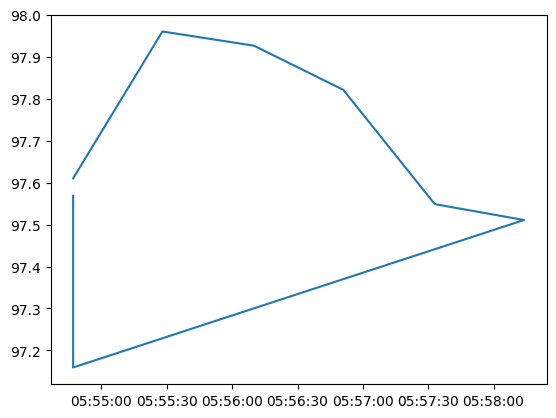

In [32]:
plt.plot(emissions['start_time'],emissions['ce'])

,start_time,stop_time,duration,cross_talk_355_353,ch4_cal,co2_cal,ce_cal,fluo_cal,z_ref,co2_ref,...,ce_m_ref,fluo_ref,z,co2,ch4,ce,ce_m,fluo,number_of_files,files
0,2024-12-05 05:54:47+00:00,2024-12-05 05:56:09+00:00,0 days 00:01:22,160,4000,26000,0.25,100,361.875,427.802385,...,-0.000076,0.095062,399.375,2122.426762,35.323394,97.366740,0.027045,3.394469,2,[.\sample_data\20241204_CEPEMA_FLARE_acima da ...
1,2024-12-05 05:56:10+00:00,2024-12-05 05:57:32+00:00,0 days 00:01:22,160,4000,26000,0.25,100,361.875,438.649856,...,0.020852,0.105045,399.375,2134.317816,25.487680,98.096392,0.019405,1.994683,2,[.\sample_data\20241204_CEPEMA_FLARE_acima da ...
2,2024-12-05 05:57:33+00:00,2024-12-05 05:58:55+00:00,0 days 00:01:22,160,4000,26000,0.25,100,361.875,415.971838,...,0.010836,0.101929,399.375,2004.830204,24.459739,98.055976,0.019826,2.322261,2,[.\sample_data\20241204_CEPEMA_FLARE_acima da ...
3,2024-12-05 05:58:55+00:00,2024-12-05 06:00:18+00:00,0 days 00:01:23,160,4000,26000,0.25,100,361.875,410.996063,...,0.010867,0.117732,399.375,2128.459288,32.822266,97.555400,0.025059,2.750864,2,[.\sample_data\20241204_CEPEMA_FLARE_acima da ...
4,2024-12-05 06:00:18+00:00,2024-12-05 06:01:41+00:00,0 days 00:01:23,160,4000,26000,0.25,100,361.875,432.004996,...,-0.000077,0.103374,399.375,2115.991360,43.219500,96.787533,0.033191,4.183625,2,[.\sample_data\20241204_CEPEMA_FLARE_acima da ...
